In [44]:
# import library
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (20,10))
sns.set(style='darkgrid')

<Figure size 1440x720 with 0 Axes>

In [50]:
# load data
hotel = pd.read_csv('new_hotel_bookings.csv',index_col='Unnamed: 0')
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119390 non-null int64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           119390 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 non

## Feature Engineering

In [4]:
# to check the feature types
hotel.dtypes

Unnamed: 0                          int64
hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                      

### Handling categorical features

In [5]:
# change hotels to 0 and 1 (City Hotel: 1, Resort Hotel: 0)
hotel['hotel'] = hotel.hotel.replace(['Resort Hotel','City Hotel'],[0,1])

In [7]:
month=['January', 'February', 'March', 'April', 'May', 'June', 'July', 
       'August', 'September', 'October', 'November', 'December']
# change arrival date month to 1 to 12
hotel['arrival_date_month'] = hotel.arrival_date_month.replace(month,np.arange(1,13))

In [8]:
# group months into seasons
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]
winter = [1,2,12]
hotel['seasons'] = hotel['arrival_date_month'].map(lambda i: "spring" if i in spring else "summer" if i in summer else "fall" if i in fall else "winter")

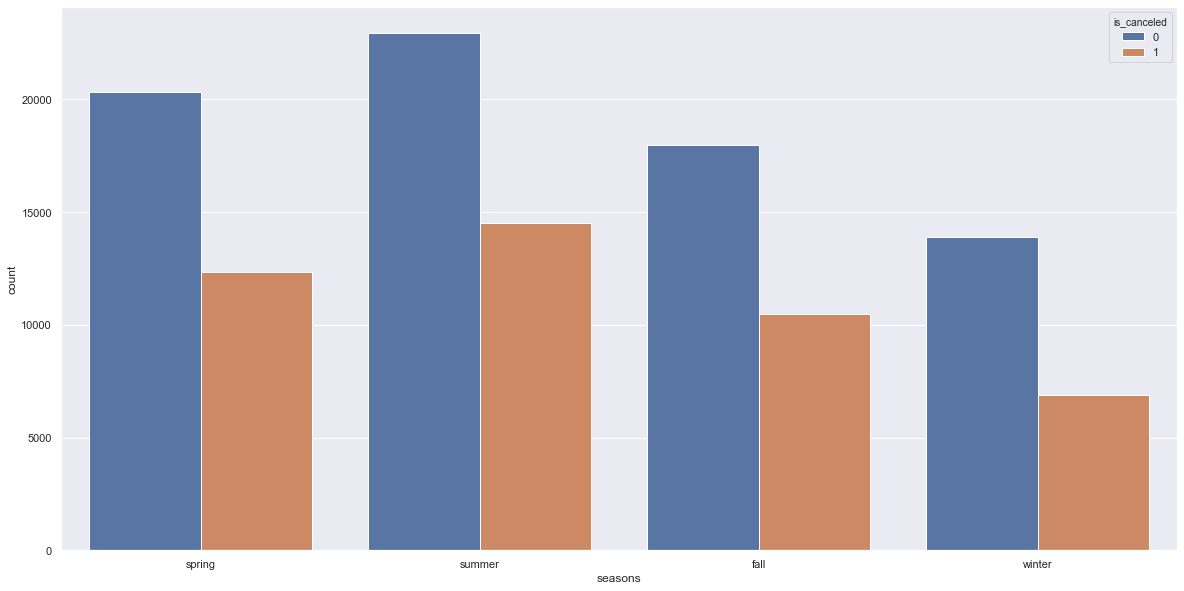

In [11]:
# bar chart for seasons
plt.figure(figsize=(20,10))
seasons = ['spring','summer','fall','winter']
sns.countplot(x = 'seasons', hue = 'is_canceled', data=hotel, order=seasons)

In [12]:
# create one-hot variavles for seasons
season_dummies = pd.get_dummies(hotel['seasons'])

# adding dummy variables into the dataset
hotel = pd.concat([hotel, season_dummies],axis=1,sort=True)

# drop the season column after adding the dummies
hotel = hotel.drop(columns=['seasons'])

In [13]:
mealdummy = pd.get_dummies(hotel['meal'],prefix ='meal')

In [14]:
# Finding the most predictive country with >80% majority label and more than 5000 entries

# Groupby country and find how many cancelled and not cancelled each country has
hotelcountrycount = hotel.groupby(['country','is_canceled'])['is_canceled'].size().reset_index(name='count_cancelled')
# hotelcountrysum= hotel.groupby('country')['is_canceled'].agg(pd.Series.sum).reset_index(name='sum') 
hotelcountrysum = hotel.groupby('country')['is_canceled'].count().reset_index(name='sum')
# left join the sum and count
countryjoined= hotelcountrycount.merge(hotelcountrysum, on='country', how='left')
# finding the percentage of each label in a country
countryjoined['percentage'] = countryjoined.apply(lambda x: x['count_cancelled']/x['sum'], axis=1)
# remove all countires whose majority label is less than 80%
countryjoined = countryjoined[countryjoined['percentage'] > 0.8]
# remove all countries whose sum is less than 5000
countryjoined= countryjoined[countryjoined['sum'] > 5000]

In [15]:
# most predictive countries. With >80% majority label and more than 5000 entries
countryjoined

,country,is_canceled,count_cancelled,sum,percentage
69,DEU,0,6069,7287,0.832853
92,FRA,0,8481,10415,0.814306


In [16]:
# FRA and DEU are the most predictive countries so they would be the dummy variables
hotel['country_is_FRA'] = hotel['country'].apply(lambda x: 1 if x == 'FRA' else 0)
hotel['country_is_DEU'] = hotel['country'].apply(lambda x: 1 if x == 'DEU' else 0)
hotel['country_is_other'] = hotel['country'].apply(lambda x: 1 if (x != 'DEU' and x!='FRA') else 0)

In [20]:
market_segment_dummy = pd.get_dummies(hotel['market_segment'],prefix ='market_segment')

In [21]:
distribution_channel_dummy = pd.get_dummies(hotel['distribution_channel'],prefix ='distribution_channel')

In [22]:
hotel = pd.concat([hotel,distribution_channel_dummy,market_segment_dummy,mealdummy],axis=1,sort=True)

### Handle numerical features

In [23]:
from sklearn import preprocessing

In [24]:
# lead time
hotel['lead_time'].skew()

1.3465498727254268

In [26]:
hotel['log_lead'] = hotel['lead_time'].map(lambda i: np.log(i) if i > 0 else 0)
hotel['log_lead'].skew()

-0.903993835862541

Perform `log( )` function on each lead time to scale the data.
#### After outliers handling

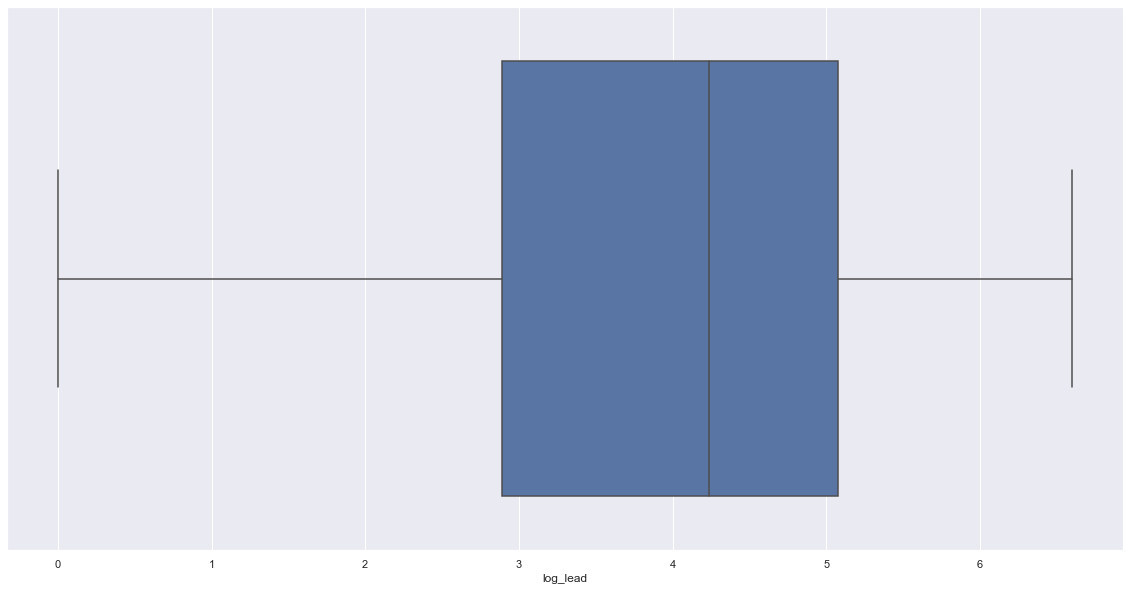

In [27]:
plt.figure(figsize = (20,10))
sns.boxplot(hotel['log_lead'])

In [28]:
# stays_in_weekend_nights
hotel['stays_in_weekend_nights'] = np.where(hotel['stays_in_weekend_nights'] > 5, 5, hotel['stays_in_weekend_nights'])

Data clipping: for each `stays_in_weekend_nights`, if it is larger than 5, change it to 5.
#### After outliers handling:

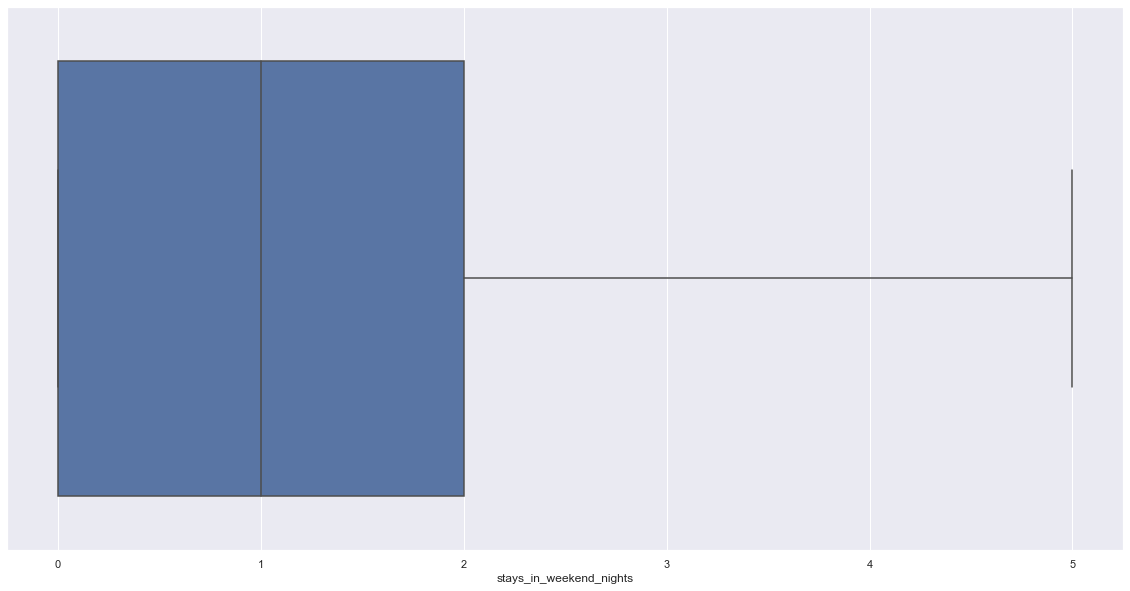

In [29]:
plt.figure(figsize = (20,10))
sns.boxplot(hotel['stays_in_weekend_nights'])

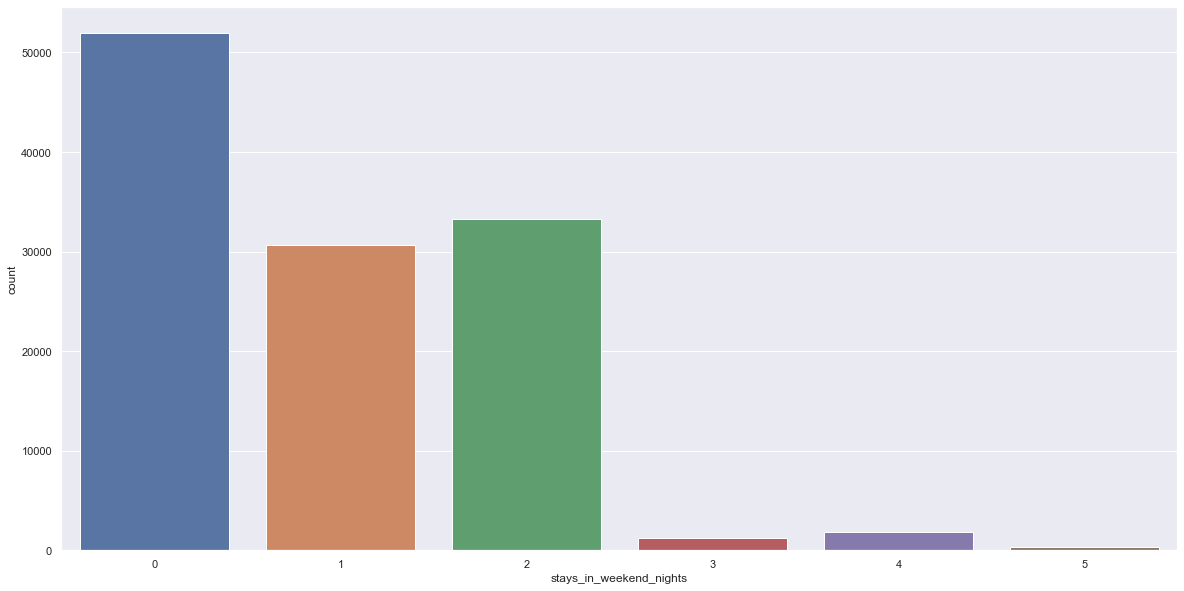

In [30]:
plt.figure(figsize = (20,10))
sns.countplot(hotel['stays_in_weekend_nights'])

In [31]:
# stays_in_week_nights
hotel['stays_in_week_nights'] = np.where(hotel['stays_in_week_nights'] > 10, 10, hotel['stays_in_week_nights'])

Data clipping: for each `stays_in_weekend_nights`, if it is larger than 5, change it to 5.
#### After outliers handling:

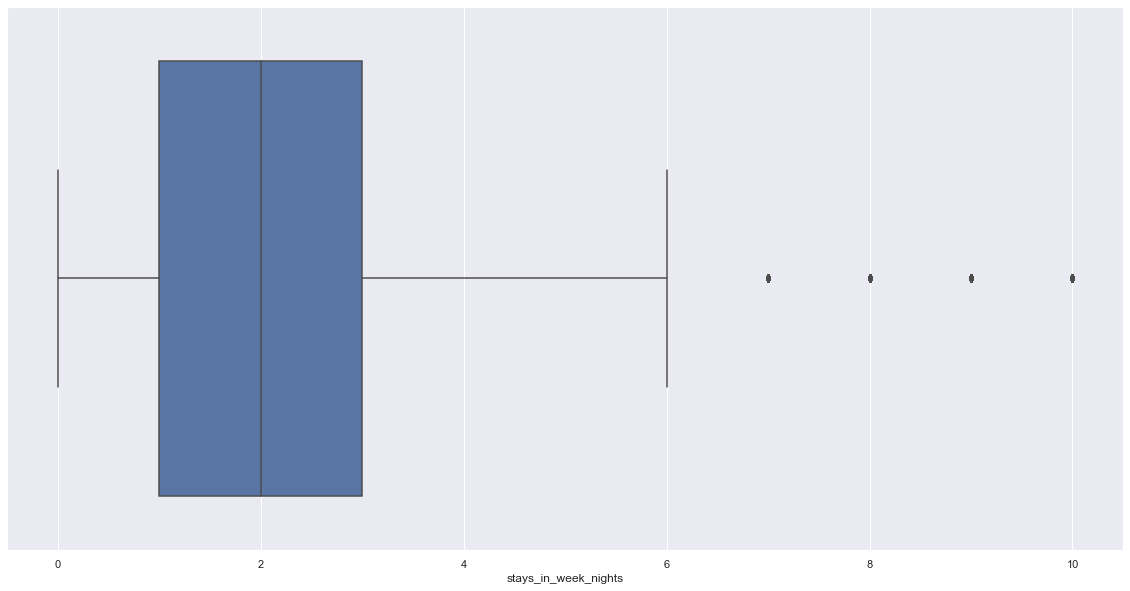

In [66]:
plt.figure(figsize = (20,10))
sns.boxplot(hotel['stays_in_week_nights'])

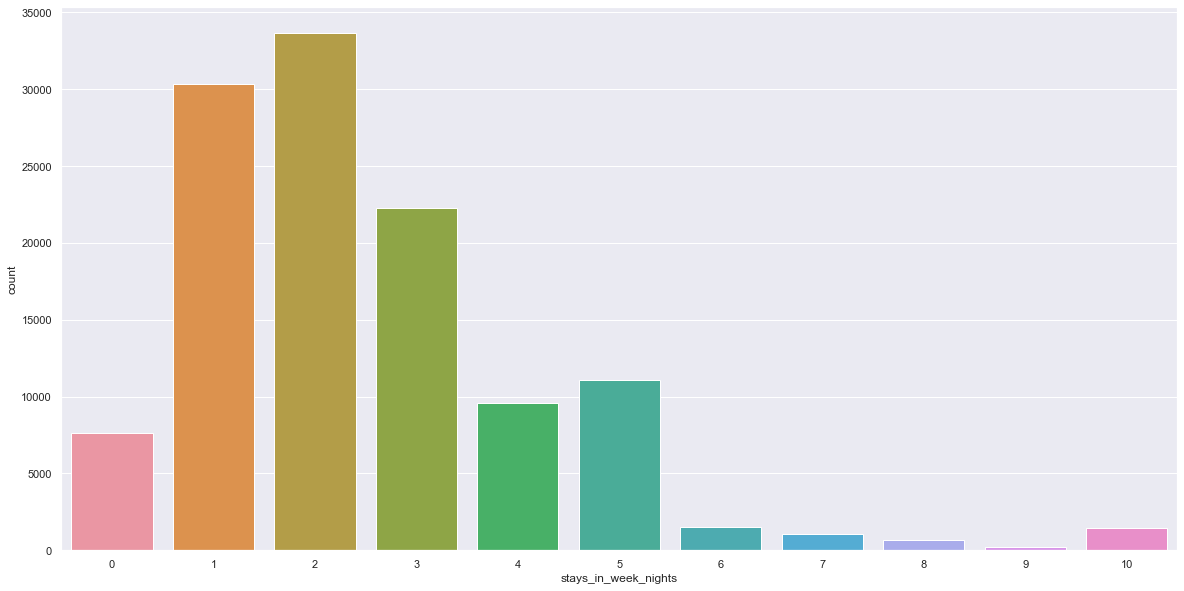

In [32]:
plt.figure(figsize = (20,10))
sns.countplot(hotel['stays_in_week_nights'])

In [33]:
# create a column indicates the total nights each customers stay
hotel['stays_in_total_nights'] = hotel['stays_in_weekend_nights'] + hotel['stays_in_week_nights']

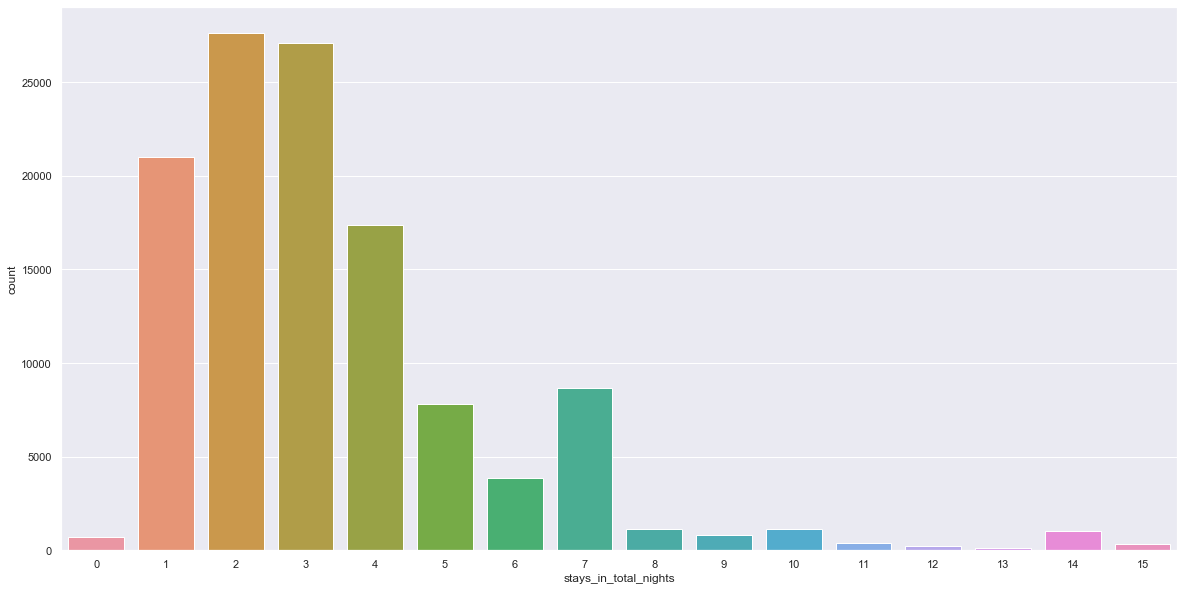

In [34]:
plt.figure(figsize = (20,10))
sns.countplot(hotel['stays_in_total_nights'])

#### Normalization

In [35]:
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['lead_time']])
hotel['lead_time_minmax']=minmax_scaler.transform(hotel[['lead_time']])
hotel['lead_time_minmax']

0         0.464043
1         1.000000
2         0.009498
3         0.017639
4         0.018996
            ...   
119385    0.031208
119386    0.138399
119387    0.046133
119388    0.147897
119389    0.278155
Name: lead_time_minmax, Length: 119390, dtype: float64

In [36]:
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['stays_in_weekend_nights']])
hotel['stays_in_weekend_nights_minmax']=minmax_scaler.transform(hotel[['stays_in_weekend_nights']])
hotel['stays_in_weekend_nights_minmax']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
119385    0.4
119386    0.4
119387    0.4
119388    0.4
119389    0.4
Name: stays_in_weekend_nights_minmax, Length: 119390, dtype: float64

In [37]:
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['stays_in_week_nights']])
hotel['stays_in_week_nights_minmax']=minmax_scaler.transform(hotel[['stays_in_week_nights']])
hotel['stays_in_week_nights_minmax']

0         0.0
1         0.0
2         0.1
3         0.1
4         0.2
         ... 
119385    0.5
119386    0.5
119387    0.5
119388    0.5
119389    0.7
Name: stays_in_week_nights_minmax, Length: 119390, dtype: float64

In [38]:
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['adults']])
hotel['adults_minmax']=minmax_scaler.transform(hotel[['adults']])
hotel['adults_minmax']

0         0.036364
1         0.036364
2         0.018182
3         0.018182
4         0.036364
            ...   
119385    0.036364
119386    0.054545
119387    0.036364
119388    0.036364
119389    0.036364
Name: adults_minmax, Length: 119390, dtype: float64

In [39]:
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['children']])
hotel['children_minmax']=minmax_scaler.transform(hotel[['children']])
hotel['children_minmax']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
119385    0.0
119386    0.0
119387    0.0
119388    0.0
119389    0.0
Name: children_minmax, Length: 119390, dtype: float64

In [40]:
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['babies']])
hotel['babies_minmax']=minmax_scaler.transform(hotel[['babies']])
hotel['babies_minmax']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
119385    0.0
119386    0.0
119387    0.0
119388    0.0
119389    0.0
Name: babies_minmax, Length: 119390, dtype: float64

### Dropping out unrelated features

In [41]:
# drop out 'arrival_date_day_of_month' since it looks random
delete_columns = ['arrival_date_day_of_month',
                  'distribution_channel',
                  'market_segment',
                  'customer_type',
                  'country',
                  'reservation_status',
                  'reservation_status_date']

hoteldrop = hotel.drop(columns=delete_columns)

In [42]:
hoteldrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 119389
Data columns (total 59 columns):
Unnamed: 0                        119390 non-null int64
hotel                             119390 non-null int64
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null int64
arrival_date_week_number          119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119390 non-null int64
babies                            119390 non-null int64
meal                              119390 non-null object
is_repeated_guest                 119390 non-null int64
previous_cancellations            119390 non-null int64
previous_bookings_not_canceled    119390 non-nul

In [43]:
# export the clean dataset to a new csv file
hoteldrop.to_csv("clean_dataset.csv")

## Correlations (after feature engineering)

In [ ]:
# look at the correlations among columns
data = dataset.copy()
data.corr()

In [ ]:
# look at the correlations with is_canceled
data.corr()['is_canceled'].sort_values()